<a href="https://colab.research.google.com/github/cseaboys/dl/blob/main/e5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q keras-tuner

Reloading Tuner from denoise_tuning/mlp_mnist_simple/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


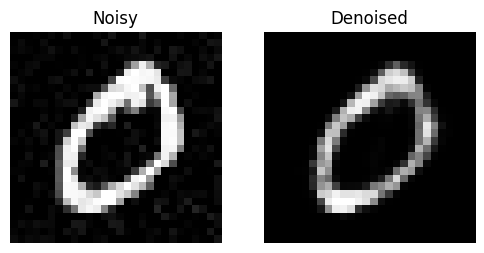

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x = x_train[:5000].astype("float32") / 255.0
x = x.reshape(len(x), -1)

# add small gaussian noise
noise = np.random.normal(0, 0.05, x.shape)
x_noisy = np.clip(x + noise, 0.0, 1.0)

# model builder for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(784,)),
        tf.keras.layers.Dense(hp.Int('units1', 128, 512, step=128), activation='relu'),
        tf.keras.layers.Dense(hp.Int('units2', 64, 256, step=64), activation='relu'),
        tf.keras.layers.Dense(784, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mse')
    return model

# tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=4,
    executions_per_trial=1,
    directory='denoise_tuning',
    project_name='mlp_mnist_simple'
)

tuner.search(x_noisy, x, epochs=6, validation_split=0.2, verbose=0)

# best model
best_model = tuner.get_best_models(num_models=1)[0]

# denoise
x_denoised = best_model.predict(x_noisy, verbose=0)

# image at index number 1
image_index = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(x_noisy[image_index].reshape(28,28), cmap='gray')
plt.title("Noisy")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(x_denoised[image_index].reshape(28,28), cmap='gray')
plt.title("Denoised")
plt.axis('off')

plt.show()